<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/huggingface-rag-cookbook/semi_structured_RAG_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Semi-structured RAG

Many documents contain a mixture of content types, including text and tables.

Semi-structured data can be challenging for conventional RAG for at least two reasons:

* Text splitting may break up tables, corrupting the data in retrieval
* Embedding tables may pose challenges for semantic similarity search

This cookbook shows how to perform RAG on documents with semi-structured data:

* We will use [Unstructured](https://unstructured.io/) to parse both text and tables from documents (PDFs).
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) to store raw tables, text along with table summaries better suited for retrieval.
* We will use [LCEL](https://python.langchain.com/docs/expression_language/) to implement the chains used.

The overall flow is here:

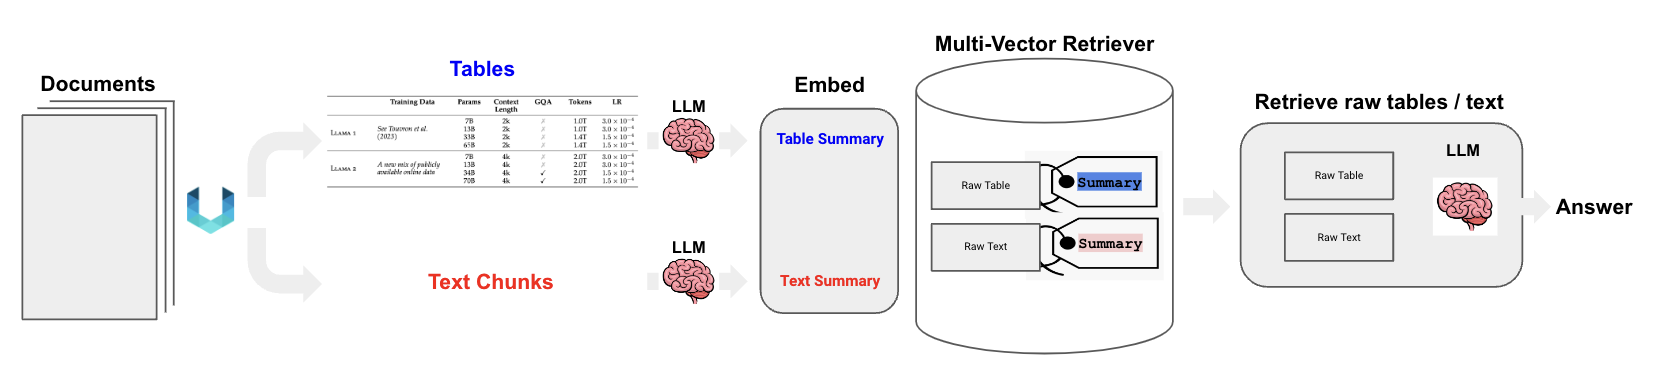

## Packages

In [ ]:
!pip install langchain unstructured[all-docs] pydantic lxml langchainhub

In [ ]:
!pip install -q torch transformers accelerate bitsandbytes sentence-transformers chromadb langchain_community

The PDF partitioning used by Unstructured will use:

* `tesseract` for Optical Character Recognition (OCR)
*  `poppler` for PDF rendering and processing

In [ ]:
!sudo apt install tesseract-ocr
!apt-get install poppler-utils

In [ ]:
!pip install tesseract
!pip install pytesseract

In [4]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

## Data Loading

### Partition PDF tables and text

Apply to the [`LLaMA2`](https://arxiv.org/pdf/2307.09288.pdf) paper.

We use the Unstructured [`partition_pdf`](https://unstructured-io.github.io/unstructured/core/partition.html#partition-pdf), which segments a PDF document by using a layout model.

This layout model makes it possible to extract elements, such as tables, from pdfs.

We also can use `Unstructured` chunking, which:

* Tries to identify document sections (e.g., Introduction, etc)
* Then, builds text blocks that maintain sections while also honoring user-defined chunk sizes

In [ ]:
!wget https://arxiv.org/pdf/2307.09288

!mv 2307.09288 LLaMA2.pdf

In [6]:
path = "/content/"

In [ ]:
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

# Get elements
raw_pdf_elements = partition_pdf(
    filename=path + "LLaMA2.pdf",
    # Unstructured first finds embedded image blocks
    extract_images_in_pdf=False,
    # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
    # Titles are any sub-section of the document
    infer_table_structure=True,
    # Post processing to aggregate text once we have the title
    chunking_strategy="by_title",
    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

We can examine the elements extracted by `partition_pdf`.

`CompositeElement` are aggregated chunks.

In [8]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 114,
 "<class 'unstructured.documents.elements.Table'>": 44,
 "<class 'unstructured.documents.elements.TableChunk'>": 6}

In [9]:
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

50
114


## Model Setup

In [10]:
from langchain.llms import HuggingFacePipeline
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

In [ ]:
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(model_name)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    do_sample=True,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=200,
    eos_token_id=terminators,
)

model = HuggingFacePipeline(pipeline=text_generation_pipeline)

## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) to produce summaries of tables and, optionally, text.

With the summary, we will also store the raw table elements.

The summaries are used to improve the quality of retrieval, [as explained in the multi vector retriever docs](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector).

The raw tables are passed to the LLM, providing the full table context for the LLM to generate the answer.  

### Summaries

In [12]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

We create a simple summarize chain for each element.

You can also see, re-use, or modify the prompt in the Hub [here](https://smith.langchain.com/hub/rlm/multi-vector-retriever-summarization).

```
from langchain import hub
obj = hub.pull("rlm/multi-vector-retriever-summarization")
```

In [13]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
# model = ChatOpenAI(temperature=0, model="gpt-4")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [ ]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [ ]:
# Apply to texts
texts = [i.text for i in text_elements]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

**Add to vectorstore**

Use [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) with summaries:

* `InMemoryStore` stores the raw text, tables
* `vectorstore` stores the embedded summaries

In [ ]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5")
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries", embedding_function=embeddings)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

## RAG

Run [RAG pipeline](https://python.langchain.com/docs/expression_language/cookbook/retrieval).

In [17]:
from langchain_core.runnables import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# LLM
# model = ChatOpenAI(temperature=0, model="gpt-4")

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [19]:
chain.invoke("What is the number of training tokens for LLaMA2?")

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


"Answer: According to the provided context, LLaMA2 was pre-trained on 2 trillion tokens of data from publicly available sources. Additionally, the fine-tuning data includes over one million new human-annotated examples. However, there is no specific mention of the number of training tokens for LLaMA2. Therefore, I'll answer based on the pre-training data, which is 2 trillion tokens."

We can check the [trace](https://smith.langchain.com/public/4739ae7c-1a13-406d-bc4e-3462670ebc01/r) to see what chunks were retrieved:

This includes Table 1 of the paper, showing the Tokens used for training.

```
Training Data Params Context GQA Tokens LR Length 7B 2k 1.0T 3.0x 10-4 See Touvron et al. 13B 2k 1.0T 3.0 x 10-4 LiaMa 1 (2023) 33B 2k 14T 1.5 x 10-4 65B 2k 1.4T 1.5 x 10-4 7B 4k 2.0T 3.0x 10-4 Liama 2 A new mix of publicly 13B 4k 2.0T 3.0 x 10-4 available online data 34B 4k v 2.0T 1.5 x 10-4 70B 4k v 2.0T 1.5 x 10-4
```